In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture as GMM
import glob
import pandas as pd
import sqlite3
import os
import warnings
from sqlalchemy import create_engine
warnings.filterwarnings("ignore", category=RuntimeWarning)

import statsmodels.api as sm
import scipy.special as ss

In [3]:
def f_norm(x, w, mu,sigma):
    f = w / (sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return f

def f_erf0(x, w, mu, sigma):
    z = (x - mu) / (2 ** 0.5) / sigma
    F_cum = - w / 2 * ss.erf(z) + w / 2
    return F_cum


def f_erf1(x, w, mu, sigma):
    z = (x - mu) / (2 ** 0.5) / sigma
    F_cum = w / 2 * ss.erf(z) + w / 2
    return F_cum

In [4]:
class image_analysis:

    def __init__(self):
        self.droplet_list = []
        self.concent_list = []
        
        self.num_total = 0
        self.num_positive = 0
        self.num_negative = 0
        
        self.portion_positive = 0
        self.threshold = 0

        
    def find_droplet(self, file_path, display_sec=False, marked_save=False):
        # Load Image
        self.file_path = file_path

        img = cv2.imread(file_path)
        img_circle = img.copy()

        # Pre-set for circle detection
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_blur = cv2.medianBlur(img_gray, 5)

        # Circle detection (Hough)
        circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT,
                                   dp=1, minDist=60,
                                   param1=30, param2=20,
                                   minRadius=40, maxRadius=80)
        
        # Draw circles on the image
        if circles is not None:
            draw_circles = np.uint32(np.array(circles))

            self.draw_circles = draw_circles
            self.img_BGR = img.copy()
            self.img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            for x, y, r in draw_circles[0, :]:
                cv2.circle(img_circle, (x, y), r, (31, 255, 62), 2)
                cv2.circle(img_circle, (x, y), 1, (0, 0, 255), 2)

            if marked_save == True:
#                 if not os.path.exists("marked"):
#                     os.makedirs("marked")
                cv2.imwrite(f"marked_{self.file_path}", img_circle)

            if type(display_sec) == int:
                n_seconds = int(display_sec)
                cv2.imshow(self.file_path, img_circle)
                k = cv2.waitKey(n_seconds * 1000)
                cv2.destroyAllWindows()
        else:
            print("None or Error")

    def measure_droplet(self):
        num_droplet = 0
        height, width, _ = self.img_BGR.shape  # Image size measure
        for x_ctr, y_ctr, r in self.draw_circles[0]:  # Iterate for every droplet
            num_droplet += 1
            print("#" + str(num_droplet), end=" ")

            num_pixel = 0
            avg_BGR = np.array([[0], [0], [0]])
            avg_HSV = np.array([[0], [0], [0]])
            for i in range(x_ctr - r, x_ctr + r + 1):  # Iterate for every pixel
                for j in range(y_ctr - r, y_ctr + r + 1):
                    if (i >= width - 1) or (i <= 1) or (j >= height - 1) or (j <= 1):
                        continue
                    elif (i - x_ctr) ** 2 + (j - y_ctr) ** 2 < r ** 2:
                        num_pixel += 1
                        avg_BGR += self.img_BGR[j][i].reshape(3, 1)
                        avg_HSV += self.img_HSV[j][i].reshape(3, 1)
            if num_pixel != 0:
                avg_BGR = avg_BGR / num_pixel
                avg_HSV = avg_HSV / num_pixel
                grayscale = avg_BGR[2][0] * 0.299 + avg_BGR[1][0] * 0.587 + avg_BGR[0][0] * 0.114
                self.droplet_list.append([self.file_path, num_droplet, x_ctr, y_ctr, r,
                                         avg_BGR[2][0], avg_BGR[1][0], avg_BGR[0][0],
                                         avg_HSV[0][0], avg_HSV[1][0], avg_HSV[2][0], grayscale])
        self.num_total += num_droplet
        self.df_droplet = pd.DataFrame(self.droplet_list, columns=["path", "#droplet", "x", "y", "radius", "R", "G", "B", "H", "S", "V", "gray"])
        
    def thresholding(self, show_graph=True):
        gray = self.df_droplet["gray"]
        norm = np.sort(np.array(gray).reshape(len(gray)))
        x_train = norm.reshape(-1, 1)
        model = GMM(2, max_iter=400, verbose_interval=30)
        model.fit(x_train,)

        r = np.argmin(model.means_[0:2])  
        w_0, w_1 = model.weights_[r], model.weights_[1-r]
        mu_0, mu_1 = model.means_[r][0], model.means_[1-r][0]
        cov = [np.sqrt(np.trace(model.covariances_[i]) / 2) for i in range(0,2)]
        sigma_0, sigma_1 = cov[r], cov[1-r]
        self.features = w_0, w_1, mu_0, mu_1, sigma_0, sigma_1
        
        x = np.linspace(0,1,1000, endpoint=False)
#         t_index = np.argwhere(np.diff(np.sign(f_erf0(x, w_0, mu_0, sigma_0) - f_erf1(x, w_1, mu_1, sigma_1)))).flatten()
#         self.threshold = x[t_index][0]
        self.portion_positive = w_1   # Positive portion
        self.num_positive = int(self.num_total * self.portion_positive)
        self.num_negative = self.num_total - self.num_positive
        
        if show_graph == True:
            x_list = x.reshape(-1, 1)
            y_list = np.exp(model.score_samples(x_list))
            plt.figure()
#             plt.hist(norm, 200, density=True, histtype='stepfilled')
            plt.plot(x, f_norm(x, w_0, mu_0, sigma_0), color='darkred')
            plt.plot(x, f_norm(x, w_1, mu_1, sigma_1), color='forestgreen')
            plt.plot(x_list, y_list, '-r')
#             plt.axvline(x=t, color='black', label="Threshold", linestyle='--')
#             plt.xlim([0, 0.2])
            plt.show()
            

    def calculate_concentration(self, reliability=0.95, magnification="10X", show=True):
        self.concent_list = []
        self.radius_mean = self.df_droplet["radius"].mean()
        self.radius_stdv = self.df_droplet["radius"].std()
        actual_radius = self.radius_mean *  0.893   # pixel to um
        droplet_volume = 4 / 3 * math.pi * (actual_radius ** 3) * math.pow(10, -9) # volume of droplet[uL]
        z = stats.norm.ppf(reliability)
        
        p_hat = self.portion_positive
        p_lower = p_hat - z * math.sqrt((p_hat * (1 - p_hat)) / self.num_total)
        p_upper = p_hat + z * math.sqrt((p_hat * (1 - p_hat)) / self.num_total)
        
        self.concentration_exact = - math.log(1 - p_hat) / droplet_volume
        self.concentration_lower = - math.log(1 - p_lower) / droplet_volume
        self.concentration_upper = - math.log(1 - p_upper) / droplet_volume
        stdev = self.concentration_exact - self.concentration_lower
        cv = 100 * stdev / self.concentration_exact
        
        self.concent_list= [[self.threshold, self.num_positive, self.num_negative, self.portion_positive, 
                           self.concentration_lower, self.concentration_upper, self.concentration_exact]]
        self.df_concent = pd.DataFrame(self.concent_list, columns=["threshold", "positive", "negative", "portion", "conc_lower", "conc_upper", "conc_exact"])

        if show == True:
            print('Average Radius of droplet:               {0:.2f}'.format(actual_radius))
            print('Number of Poitive calls:                 {0:.2f}'.format(self.num_positive))
            print('Number of Negative calls:                {0:.2f}'.format(self.num_negative))
            print('Propability of positive partition:       {0:.2f} \n'.format(self.portion_positive))

            print('Estimated concentration:                 {0:.3f} copies/uL'.format(self.concentration_exact))
            print('Standard deviation:                      {0:.3f} copies/uL'.format(stdev))
            print('Coefficient of variation (CV):           {0:.3f} %'.format(cv))
            print('Lower bound of 95% Confidence intervall: {0:.3f} copies/uL'.format(self.concentration_lower))
            print('Upper bound of 95% Confidence intervall: {0:.3f} copies/uL'.format(self.concentration_upper))

    def save_droplet_data(self, csv=False, sql=False):
        if csv == True:
            self.df_droplet.to_csv("Droplet.csv", sep=',', index=False, header=["path", "#droplet", "x", "y", "radius", "R", "G", "B", "H", "S", "V", "gray"])
            self.df_concent.to_csv("Concentration.csv", sep=',', index=False, header=["threshold", "positive", "negative", "portion_pos", "conc_lower", "conc_upper", "conc_exact"])
        if sql == True:
            engine = create_engine('sqlite:///Output.db', echo=False)
            sqlite_connection = engine.connect()
            self.df_droplet.to_sql("Droplet_table", sqlite_connection, if_exists='replace')
            self.df_concent.to_sql("Concentration_table", sqlite_connection, if_exists='replace')
            sqlite_connection.close()

# Analysis



Image1 #1 #2 #3 #4 #5 #6 #7 #8 #9 #10 #11 #12 #13 #14 #15 #16 #17 #18 #19 #20 #21 #22 #23 #24 #25 #26 #27 #28 #29 #30 #31 #32 #33 #34 #35 #36 #37 #38 #39 #40 #41 #42 #43 #44 #45 #46 #47 #48 #49 #50 #51 #52 #53 #54 #55 #56 #57 #58 #59 #60 #61 #62 #63 #64 #65 #66 #67 #68 #69 #70 #71 #72 #73 #74 #75 #76 #77 #78 #79 #80 #81 #82 #83 #84 #85 #86 #87 #88 #89 #90 #91 #92 #93 #94 

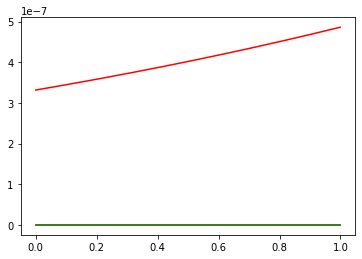

Average Radius of droplet:               56.41
Number of Poitive calls:                 38.00
Number of Negative calls:                56.00
Propability of positive partition:       0.41 

Estimated concentration:                 705.984 copies/uL
Standard deviation:                      176.563 copies/uL
Coefficient of variation (CV):           25.010 %
Lower bound of 95% Confidence intervall: 529.420 copies/uL
Upper bound of 95% Confidence intervall: 909.630 copies/uL


In [5]:
RPA = image_analysis()

for i, img_path in enumerate(glob.glob("[!marked_]*.jpg")):
    print(f"\n\nImage{i+1}", end=" ")
    RPA.find_droplet(img_path, display_sec=3, marked_save=True)
    RPA.measure_droplet()

RPA.thresholding(show_graph=True)
RPA.calculate_concentration(reliability=0.95, magnification="X10")ㅇ
RPA.save_droplet_data(csv=True, sql=True)